
Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


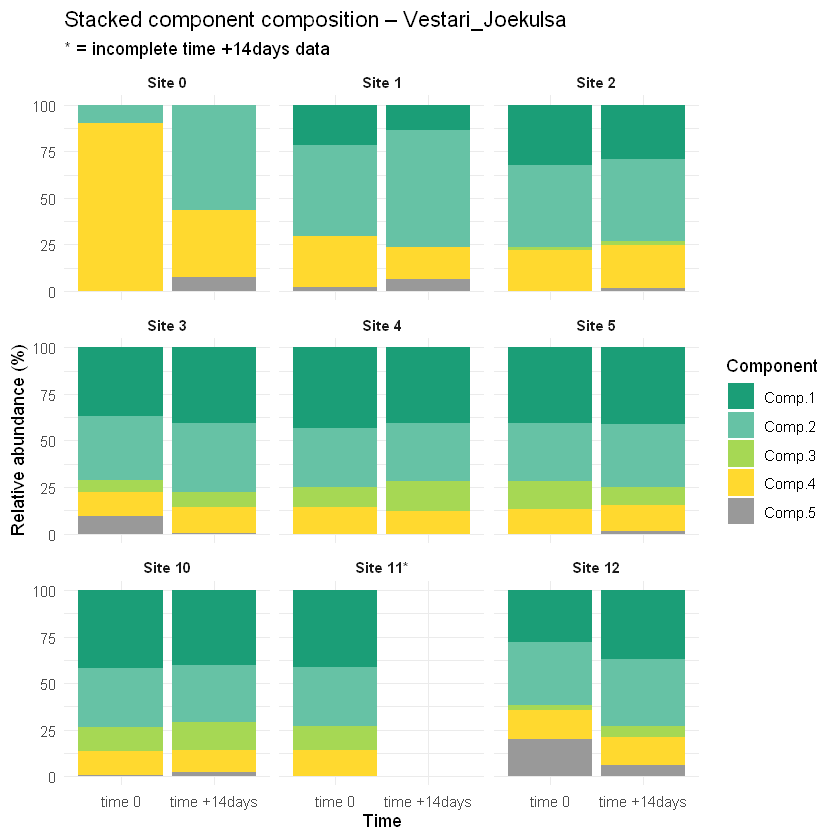

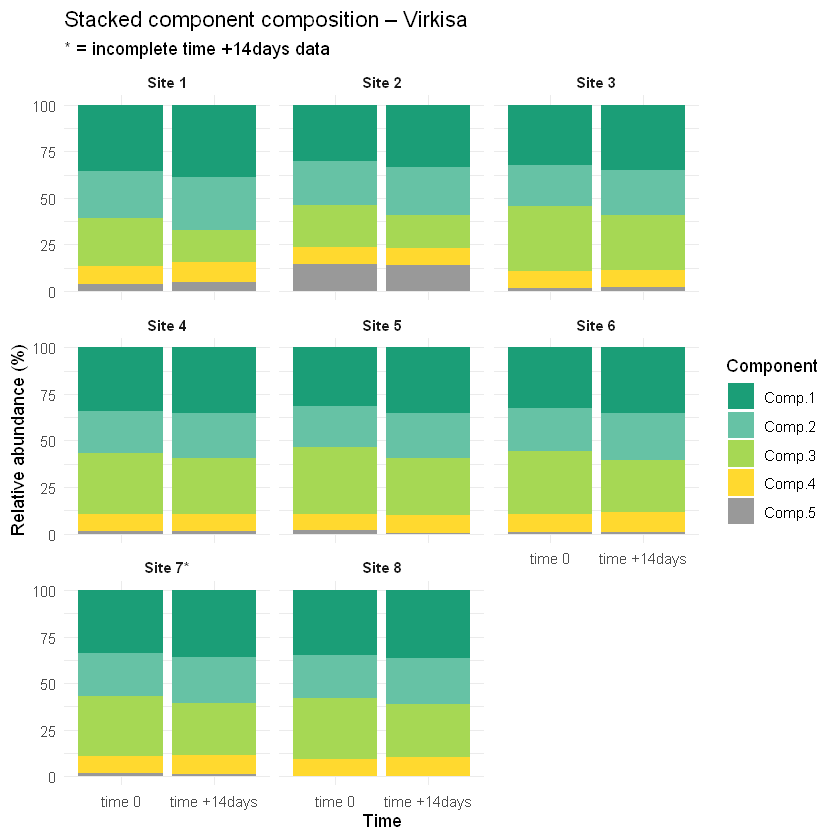

In [2]:
## Hüsch und final

# Load packages
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Load Excel file
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path)

# 2. Identify problematic sites where sum of time+14days components ≠ 100%
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3. Transform data to long format
df_long <- df %>%
  # time 0
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # time +14days
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4. Calculate mean and normalize to 100% per site and timepoint
df_normalized <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5. Mark problematic sites with *
df_normalized <- df_normalized %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel = ifelse(is_problem,
                       paste0("Site ", site_nr, "*"),
                       paste0("Site ", site_nr))
  )

# 6. Sort sites numerically
site_order <- df_normalized %>%
  distinct(site_nr, SiteLabel) %>%
  arrange(site_nr) %>%
  pull(SiteLabel)

df_normalized$SiteLabel <- factor(df_normalized$SiteLabel, levels = site_order)

# 7. Component labels and new gradient-inspired color palette
component_labels <- c(
  "pctComp.1" = "Comp.1",
  "pctComp.2" = "Comp.2",
  "pctComp.3" = "Comp.3",
  "pctComp.4" = "Comp.4",
  "pctComp.5" = "Comp.5"
)

component_colors <- c(
  "Comp.1" = "#1b9e77",  # kräftiges Türkis-Grün
  "Comp.2" = "#66c2a5",  # helleres Türkis
  "Comp.3" = "#a6d854",  # gelb-grün
  "Comp.4" = "#ffd92f",  # gelb
  "Comp.5" = "#999999"   # grau
)

# Apply labels
df_normalized$ComponentLabel <- component_labels[as.character(df_normalized$Component)]
df_normalized$ComponentLabel <- factor(df_normalized$ComponentLabel, levels = names(component_colors))

# 8. Plot by river
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)",
      fill = "Component"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


In [3]:
df_river %>% filter(is.na(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


In [4]:
df_river %>% filter(Percent < 0 | Percent > 100 | is.infinite(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


💬 Zusammenfassung

    ✅ Kein NA → geprüft ✔️

    ✅ Kein <0 oder >100 → geprüft ✔️

    ✅ Keine unendlichen Werte → geprüft ✔️

    ✅ Warnung kommt nur von leeren Slots bei Facets → harmlos

### als Tabellen

In [5]:
library(dplyr)
library(tidyr)

# Time-Faktor vorbereiten
df_long <- df_long %>%
  mutate(Time = factor(Time, levels = c("time 0", "time +14days")))

# Normalisiert
df_summary_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

# Pro Fluss Tabellen
rivers <- unique(df_summary_norm$river_name)

tables_norm <- list()

for (river in rivers) {
  df_river <- df_summary_norm %>% filter(river_name == river)
  
  # Component-Namen schöner
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  # Pivot
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_norm[[river]] <- df_pivot
}

tables_norm


$Vestari_Joekulsa
# A tibble: 5 × 20
  river_name   Component `0_time 0` `0_time +14days` `1_time 0` `1_time +14days`
  <chr>        <fct>          <dbl>            <dbl>      <dbl>            <dbl>
1 Vestari_Joe… Comp.1          0                 0        21.9             13.7 
2 Vestari_Joe… Comp.2          9.76             56.6      48.5             62.9 
3 Vestari_Joe… Comp.3          0.23              0         0.21             0.01
4 Vestari_Joe… Comp.4         90.0              35.9      27.2             17.2 
5 Vestari_Joe… Comp.5          0                 7.5       2.22             6.22
# ℹ 14 more variables: `2_time 0` <dbl>, `2_time +14days` <dbl>,
#   `3_time 0` <dbl>, `3_time +14days` <dbl>, `4_time 0` <dbl>,
#   `4_time +14days` <dbl>, `5_time 0` <dbl>, `5_time +14days` <dbl>,
#   `10_time 0` <dbl>, `10_time +14days` <dbl>, `11_time 0` <dbl>,
#   `11_time +14days` <dbl>, `12_time 0` <dbl>, `12_time +14days` <dbl>

$Virkisa
# A tibble: 5 × 18
  river_name Component `1_time 0` `1_time +14days` `2_time 0` `2_time +14days`
  <chr>      <fct>          <dbl>            <dbl>      <dbl>            <dbl>
1 Virkisa    Comp.1         35.8             38.6        30.4            33.4 
2 Virkisa    Comp.2         24.9             28.6        23.2            25.9 
3 Virkisa    Comp.3         25.9             17.4        22.9            17.4 
4 Virkisa    Comp.4          9.91            10.8         8.9             9.63
5 Virkisa    Comp.5          3.46             4.51       14.5            13.6 
# ℹ 12 more variables: `3_time 0` <dbl>, `3_time +14days` <dbl>,
#   `4_time 0` <dbl>, `4_time +14days` <dbl>, `5_time 0` <dbl>,
#   `5_time +14days` <dbl>, `6_time 0` <dbl>, `6_time +14days` <dbl>,
#   `7_time 0` <dbl>, `7_time +14days` <dbl>, `8_time 0` <dbl>,
#   `8_time +14days` <dbl>

In [6]:
# Unnormalisiert
df_summary_raw <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

tables_raw <- list()

for (river in rivers) {
  df_river <- df_summary_raw %>% filter(river_name == river)
  
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_raw[[river]] <- df_pivot
}

tables_raw


$Vestari_Joekulsa
# A tibble: 5 × 20
  river_name   Component `0_time 0` `0_time +14days` `1_time 0` `1_time +14days`
  <chr>        <fct>          <dbl>            <dbl>      <dbl>            <dbl>
1 Vestari_Joe… Comp.1           0               0          0.22             0.14
2 Vestari_Joe… Comp.2           0.1             0.57       0.49             0.63
3 Vestari_Joe… Comp.3           0               0          0                0   
4 Vestari_Joe… Comp.4           0.9             0.36       0.27             0.17
5 Vestari_Joe… Comp.5           0               0.07       0.02             0.06
# ℹ 14 more variables: `2_time 0` <dbl>, `2_time +14days` <dbl>,
#   `3_time 0` <dbl>, `3_time +14days` <dbl>, `4_time 0` <dbl>,
#   `4_time +14days` <dbl>, `5_time 0` <dbl>, `5_time +14days` <dbl>,
#   `10_time 0` <dbl>, `10_time +14days` <dbl>, `11_time 0` <dbl>,
#   `11_time +14days` <dbl>, `12_time 0` <dbl>, `12_time +14days` <dbl>

$Virkisa
# A tibble: 5 × 18
  river_name Component `1_time 0` `1_time +14days` `2_time 0` `2_time +14days`
  <chr>      <fct>          <dbl>            <dbl>      <dbl>            <dbl>
1 Virkisa    Comp.1          0.36             0.39       0.3              0.33
2 Virkisa    Comp.2          0.25             0.29       0.23             0.26
3 Virkisa    Comp.3          0.26             0.17       0.23             0.17
4 Virkisa    Comp.4          0.1              0.11       0.09             0.1 
5 Virkisa    Comp.5          0.03             0.05       0.15             0.14
# ℹ 12 more variables: `3_time 0` <dbl>, `3_time +14days` <dbl>,
#   `4_time 0` <dbl>, `4_time +14days` <dbl>, `5_time 0` <dbl>,
#   `5_time +14days` <dbl>, `6_time 0` <dbl>, `6_time +14days` <dbl>,
#   `7_time 0` <dbl>, `7_time +14days` <dbl>, `8_time 0` <dbl>,
#   `8_time +14days` <dbl>

# Mit prozentangaben

Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


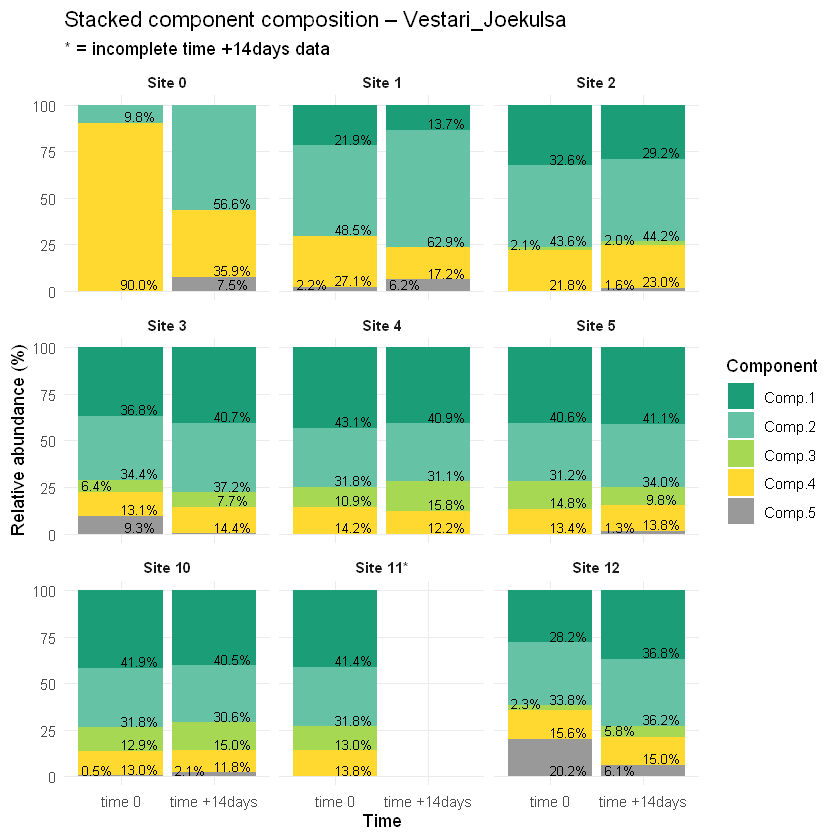

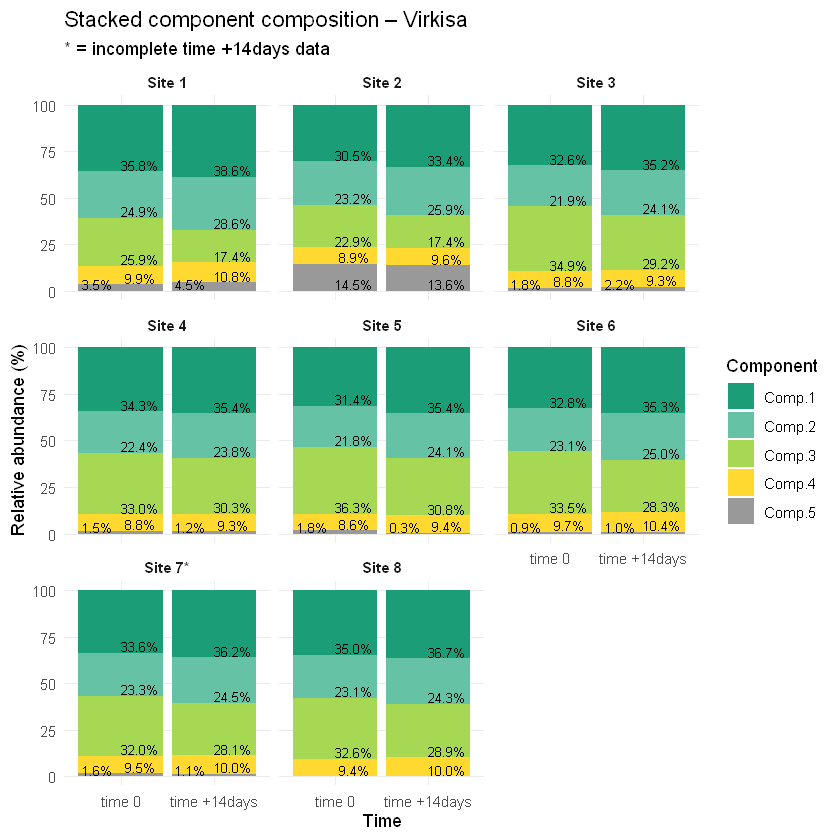

In [10]:
# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
})

# 1) Daten laden (Windows-Pfad, Fallback: /mnt/data)
win_file <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
in_file  <- if (file.exists(win_file)) win_file else "/mnt/data/MASTER_DATA_Components.xlsx"
df <- read_excel(in_file)

# 2) Problem-Sites markieren (Summe der _B-Komponenten != 100 %)
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3) Long-Format (time 0 und time +14days)
df_long <- df %>%
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = c(pctComp.1:pctComp.5), names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B$", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"), names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4) Mittelwert je Site/Time & auf 100 % normieren
df_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5) Problem-Sites kennzeichnen und Site-Labels ordnen
df_norm <- df_norm %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel  = ifelse(is_problem, paste0("Site ", site_nr, "*"), paste0("Site ", site_nr))
  )
site_order <- df_norm %>% distinct(site_nr, SiteLabel) %>% arrange(site_nr) %>% pull(SiteLabel)
df_norm$SiteLabel <- factor(df_norm$SiteLabel, levels = site_order)

# 6) Farben & Anzeigenamen
component_labels <- c(
  "pctComp.1"="Comp.1","pctComp.2"="Comp.2","pctComp.3"="Comp.3",
  "pctComp.4"="Comp.4","pctComp.5"="Comp.5"
)
component_colors <- c(
  "Comp.1"="#1b9e77","Comp.2"="#66c2a5","Comp.3"="#a6d854","Comp.4"="#ffd92f","Comp.5"="#999999"
)
df_norm <- df_norm %>%
  mutate(ComponentLabel = factor(component_labels[as.character(Component)],
                                 levels = names(component_colors)))

# 7) Label-Tabelle: Text, hjust nach 3%-Regel, Position knapp über der unteren Segmentlinie
labels_df <- df_norm %>%
  group_by(river_name, site_nr, Time) %>%
  arrange(Component, .by_group = TRUE) %>%  # Reihenfolge Comp.1..5 bleibt
  ungroup() %>%
  mutate(
    label_txt = ifelse(round(Percent, 1) <= 0.2, NA_character_,
                       paste0(format(round(Percent, 1), nsmall = 1), "%")),
    hjust_val = ifelse(Percent < 6.5, 1.25, 0)   # <3% rechtsbündig, sonst links
  )

# 8) Plot je Fluss
for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>% filter(river_name == river)
  l <- labels_df %>% filter(river_name == river)

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    # Labels: Position exakt auf der unteren Segmentlinie (vjust leicht negativ = "über der Linie")
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15, size = 2.7, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100)) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank()
    )

  print(p)
}


In [8]:
# ---- Export Setup ----
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# A4 Maße in Zoll (210 × 297 mm)
a4_width  <- 210 / 25.4   # ~8.27 inch
a4_height <- 297 / 25.4   # ~11.7 inch

# ---- Plot + Save je Fluss ----
for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>% filter(river_name == river)
  l <- labels_df %>% filter(river_name == river)

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15, size = 3, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100)) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank()
    )

  # ---- Speichern als PNG ----
  ggsave(
    filename = file.path(out_dir, paste0("Saeulen_", river, ".png")),
    plot = p,
    width = a4_width, height = a4_height, units = "in", dpi = 300
  )
}


Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


In [9]:
# ---- Plot + Export (A4-optimiert) ----

# Ausgabeordner
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# A4 in cm
a4_w_cm <- 21.0
a4_h_cm <- 29.7

for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>% filter(river_name == river)
  l <- labels_df %>% filter(river_name == river)

  # adaptive Spaltenzahl für Facets (max. 4 pro Zeile für A4 hochkant)
  n_sites <- length(unique(d$SiteLabel))
  ncol_fw <- min(4, n_sites)

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15, size = 2.6, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed", ncol = ncol_fw) +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100), clip = "off") +
    theme_minimal(base_size = 12) +
    theme(
      plot.margin = margin(6, 8, 6, 8),          # Ränder in pt
      strip.text = element_text(face = "bold", size = 11),
      axis.title = element_text(size = 11),
      axis.text = element_text(size = 9),
      legend.position = "bottom",
      legend.title = element_text(size = 10),
      legend.text  = element_text(size = 9),
      legend.box = "horizontal",
      panel.grid.minor = element_blank(),
      panel.spacing = unit(4, "pt")              # engeres Facet-Spacing
    ) +
    guides(fill = guide_legend(nrow = 1, byrow = TRUE))

  # Speichern als PNG (DIN A4 hochkant, 300 dpi)
  ggsave(
    filename = file.path(out_dir, paste0("Saeulen_", river, ".png")),
    plot = p, width = a4_w_cm, height = a4_h_cm, units = "cm", dpi = 300
  )
}


Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


In [11]:
df_norm %>% filter(is.na(Percent) | Percent < 0 | Percent > 100)


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>
Vestari_Joekulsa,11,time +14days,pctComp.1,NaN,TRUE,Site 11*,Comp.1
Vestari_Joekulsa,11,time +14days,pctComp.2,NaN,TRUE,Site 11*,Comp.2
Vestari_Joekulsa,11,time +14days,pctComp.3,NaN,TRUE,Site 11*,Comp.3
Vestari_Joekulsa,11,time +14days,pctComp.4,NaN,TRUE,Site 11*,Comp.4
Vestari_Joekulsa,11,time +14days,pctComp.5,NaN,TRUE,Site 11*,Comp.5


In [13]:
# ---- Plot + Export (DIN A4 quer) ----
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

a4_w_cm <- 29.7   # Breite (quer)
a4_h_cm <- 21.0   # Höhe

for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>%
    filter(river_name == river, !is.na(Percent), Percent >= 0, Percent <= 100)
  l <- labels_df %>%
    filter(river_name == river, !is.na(Percent), Percent >= 0, Percent <= 100, !is.na(label_txt))

  n_sites <- length(unique(d$SiteLabel))
  ncol_fw <- min(6, n_sites)  # mehr Facets pro Zeile im Querformat

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15,
      size = 3.2, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed", ncol = ncol_fw) +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100), clip = "off") +
    theme_minimal(base_size = 12) +
    theme(
      plot.margin = margin(6, 8, 6, 8),
      strip.text = element_text(face = "bold", size = 11),
      axis.title  = element_text(size = 11),
      axis.text   = element_text(size = 9),
      legend.position = "bottom",
      legend.title = element_text(size = 10),
      legend.text  = element_text(size = 9),
      legend.box = "horizontal",
      panel.grid.minor = element_blank(),
      panel.spacing = unit(4, "pt")
    ) +
    guides(fill = guide_legend(nrow = 1, byrow = TRUE))

  ggsave(
    filename = file.path(out_dir, paste0("Saeulen_A4quer_", river, ".png")),
    plot = p,
    width = a4_w_cm, height = a4_h_cm, units = "cm", dpi = 300
  )
}


# Alluvial Diagramm


Warning message:
"Paket 'ggalluvial' wird gerade benutzt und deshab nicht installiert"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <92>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in '

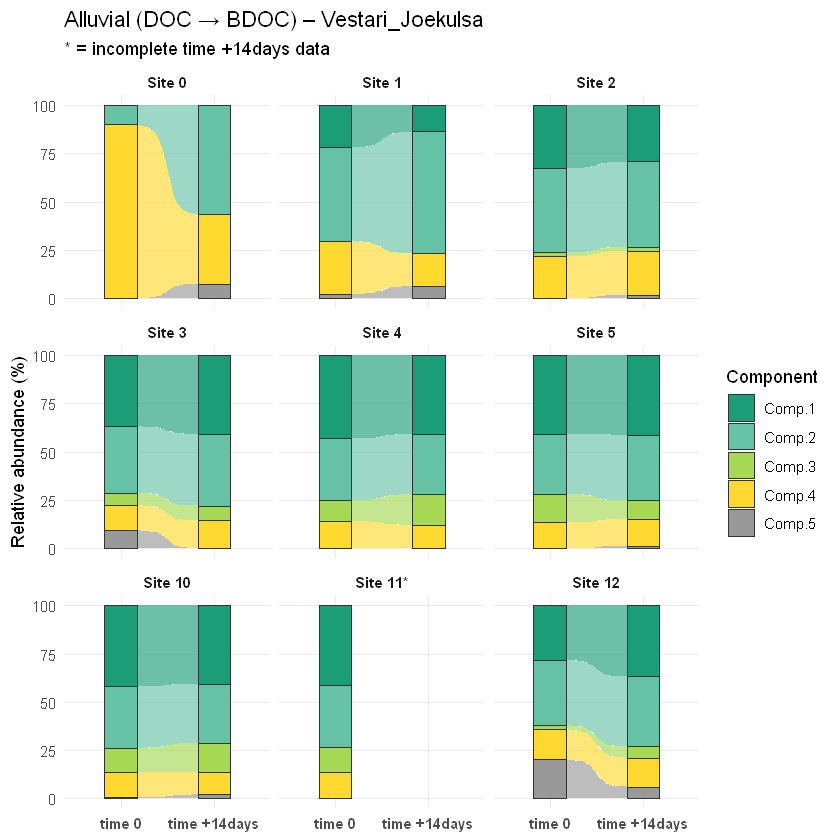

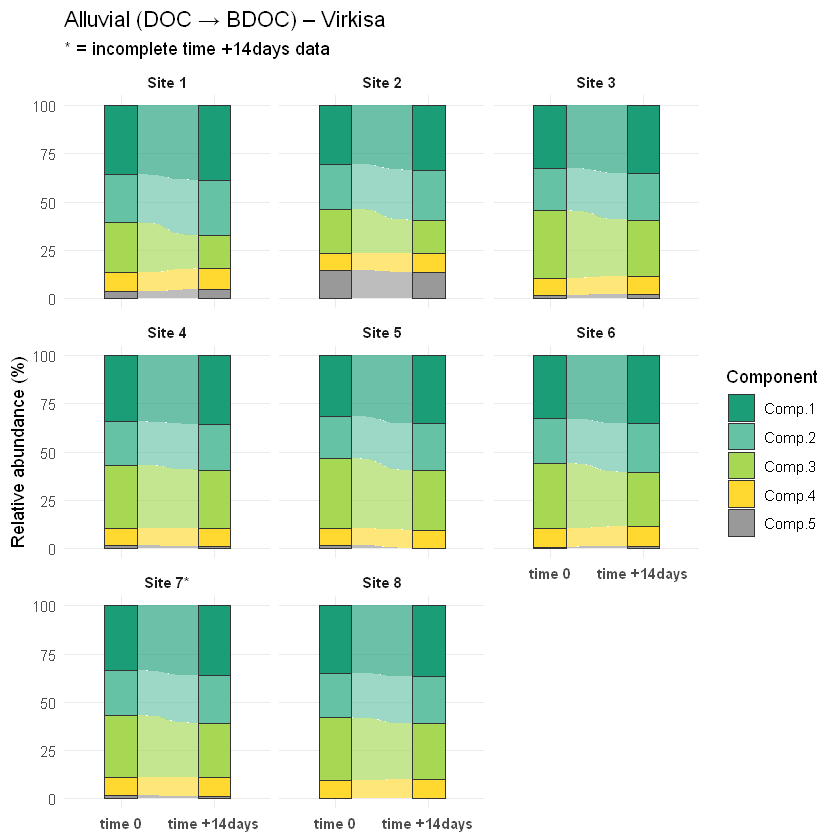

In [3]:
install.packages("ggalluvial")

# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
  # install.packages("ggalluvial")
  library(ggalluvial)
})

# 1) Daten laden (Windows-Pfad, Fallback: /mnt/data)
win_file <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
in_file  <- if (file.exists(win_file)) win_file else "/mnt/data/MASTER_DATA_Components.xlsx"
df <- read_excel(in_file)

# 2) Problem-Sites markieren (Summe der _B-Komponenten != 100 %)
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3) Long-Format (time 0 und time +14days)
df_long <- df %>%
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = c(pctComp.1:pctComp.5), names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B$", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"), names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    # falls die Quelle 0..1 ist → in %
    Percent = ifelse(!is.na(Percent) & Percent <= 1, Percent * 100, Percent),
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4) Mittelwert je Site/Time & auf 100 % normieren
df_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5) Problem-Sites kennzeichnen und Site-Labels ordnen
df_norm <- df_norm %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel  = ifelse(is_problem, paste0("Site ", site_nr, "*"), paste0("Site ", site_nr))
  )
site_order <- df_norm %>% distinct(site_nr, SiteLabel) %>% arrange(site_nr) %>% pull(SiteLabel)
df_norm$SiteLabel <- factor(df_norm$SiteLabel, levels = site_order)

# 6) Farben & Anzeigenamen (wie bei dir)
component_labels <- c(
  "pctComp.1"="Comp.1","pctComp.2"="Comp.2","pctComp.3"="Comp.3",
  "pctComp.4"="Comp.4","pctComp.5"="Comp.5"
)
component_colors <- c(
  "Comp.1"="#1b9e77","Comp.2"="#66c2a5","Comp.3"="#a6d854",
  "Comp.4"="#ffd92f","Comp.5"="#999999"
)
df_norm <- df_norm %>%
  mutate(ComponentLabel = factor(component_labels[as.character(Component)],
                                 levels = names(component_colors)))

# 7) Nur Paare mit beiden Zeiten (Alluvial braucht DOC & BDOC)
pairs_ok <- df_norm %>%
  distinct(river_name, site_nr, Time) %>%
  count(river_name, site_nr) %>%
  filter(n == 2) %>%
  transmute(river_name, site_nr)

df_plot <- df_norm %>%
  inner_join(pairs_ok, by = c("river_name","site_nr"))

# 8) Alluvial-/Sankey-Plot (robuste Version)
for (river in unique(df_plot$river_name)) {
  d <- df_plot %>%
    filter(river_name == river) %>%
    filter(!is.na(Percent)) %>%
    mutate(
      # alluvium muss JE Komponente × Site eindeutig sein:
      allu_id = interaction(river_name, site_nr, ComponentLabel, drop = TRUE),
      # ggalluvial mag es, wenn x ein geordneter Faktor ist:
      Time = factor(Time, levels = c("time 0", "time +14days")),
      # ganz kleine/Null-Werte optional kappen (verhindert dünne „Fäden“)
      Percent = ifelse(Percent < 1e-6, 0, Percent)
    )

  # optionaler Selbsttest (kannst du auskommentieren):
  # stopifnot(ggalluvial::is_alluvia_form(
  #   d %>% select(Time, ComponentLabel, allu_id, Percent) %>%
  #     rename(x = Time, stratum = ComponentLabel, alluvium = allu_id, y = Percent),
  #   axes = 1, silent = TRUE
  # ))

  p_alluvial <- ggplot(
    d,
    aes(x = Time,
        stratum  = ComponentLabel,
        alluvium = allu_id,         # jetzt pro Site×Komponente eindeutig
        y = Percent,
        fill = ComponentLabel,
        label = ComponentLabel)
  ) +
    ggalluvial::geom_alluvium(alpha = 0.65, knot.pos = 0.4) +  # statt geom_flow()
    ggalluvial::geom_stratum(width = 0.35, color = "grey20") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    coord_cartesian(ylim = c(0, 100)) +
    labs(
      title = paste("Alluvial (DOC → BDOC) –", river),
      subtitle = "* = incomplete time +14days data",
      x = NULL, y = "Relative abundance (%)", fill = "Component"
    ) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text.x = element_text(face = "bold")
    )

  print(p_alluvial)
}


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <92>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call.graphics(C_text, as.graph

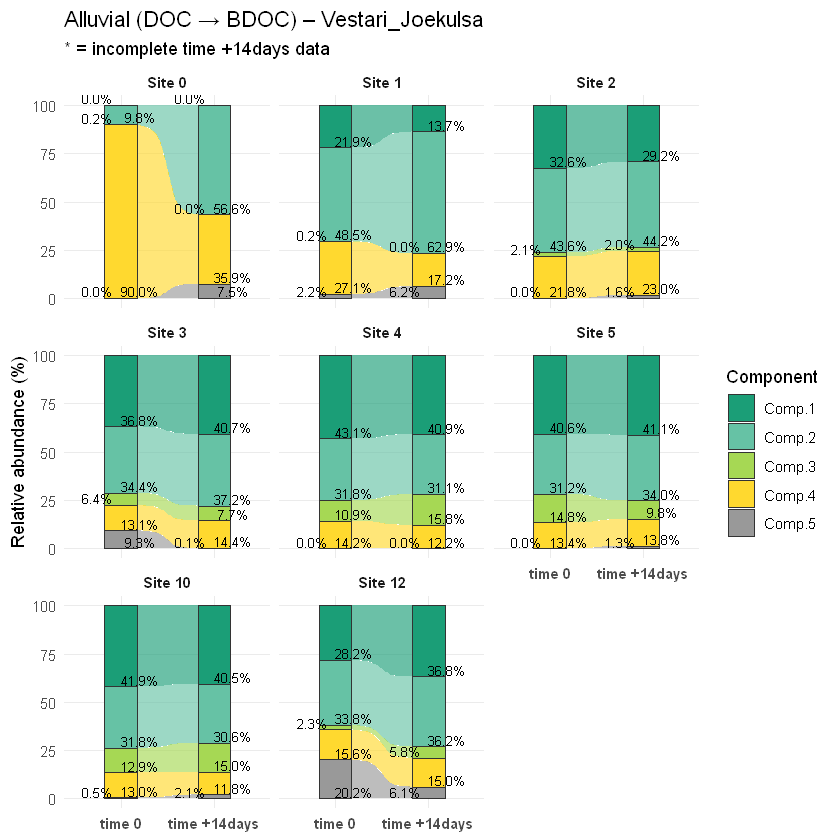

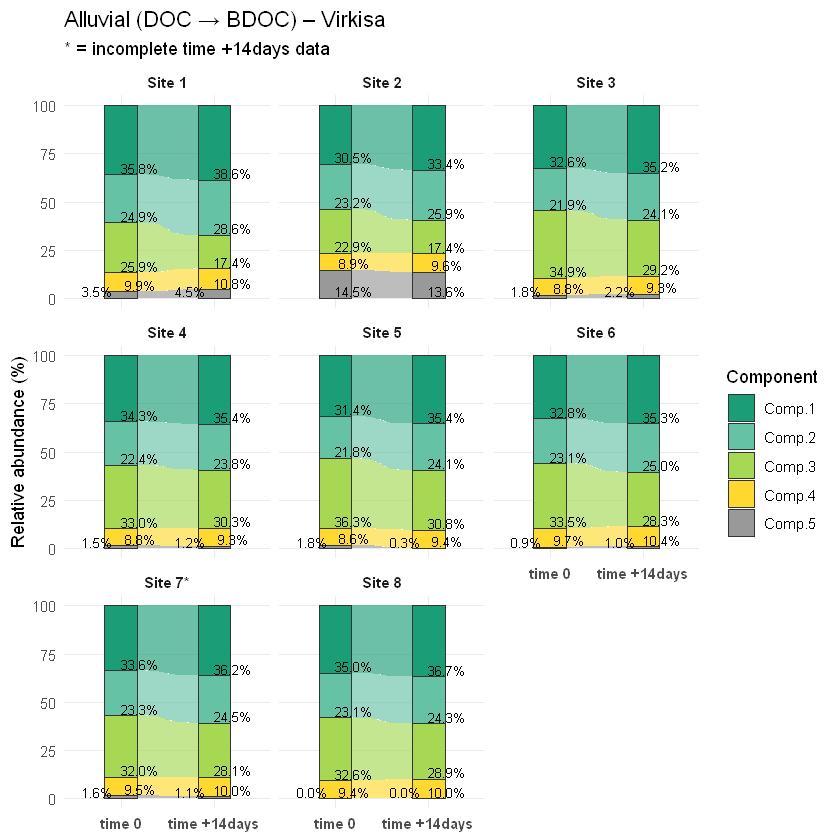

In [4]:
# 8) Alluvial-/Sankey-Plot mit echten Prozent-Labels (alle Segmente, versetzt)
for (river in unique(df_plot$river_name)) {
  d <- df_plot %>%
    filter(river_name == river) %>%
    filter(!is.na(Percent)) %>%
    mutate(
      allu_id = interaction(river_name, site_nr, ComponentLabel, drop = TRUE),
      Time = factor(Time, levels = c("time 0", "time +14days")),
      Percent = ifelse(Percent < 1e-6, 0, Percent),
      label_txt = paste0(format(round(Percent, 1), nsmall = 1), "%"),
      # kleine Segmente rechtsbündig, größere linksbündig
      hjust_val = ifelse(Percent < 6.5, 1.25, 0)
    ) %>%
    add_count(allu_id, Time) %>%
    group_by(allu_id) %>%
    filter(n_distinct(Time) == 2) %>%
    ungroup()

  p_alluvial <- ggplot(
    d,
    aes(x = Time,
        stratum  = ComponentLabel,
        alluvium = allu_id,
        y = Percent,
        fill = ComponentLabel)
  ) +
    ggalluvial::geom_alluvium(alpha = 0.65, knot.pos = 0.4) +
    ggalluvial::geom_stratum(width = 0.35, color = "grey20") +
    # >>> Labels aus den Original-Daten (Percent) <<<
    geom_text(
      data = d,
      aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0),   # exakt auf unterer Segmentlinie
      vjust = -0.15,
      size = 2.7,
      na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    coord_cartesian(ylim = c(0, 100)) +
    labs(
      title = paste("Alluvial (DOC → BDOC) –", river),
      subtitle = "* = incomplete time +14days data",
      x = NULL, y = "Relative abundance (%)", fill = "Component"
    ) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text.x = element_text(face = "bold")
    )

  print(p_alluvial)
}


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <92>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Vestari_Joekulsa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call.graphics(C_text, as.graph

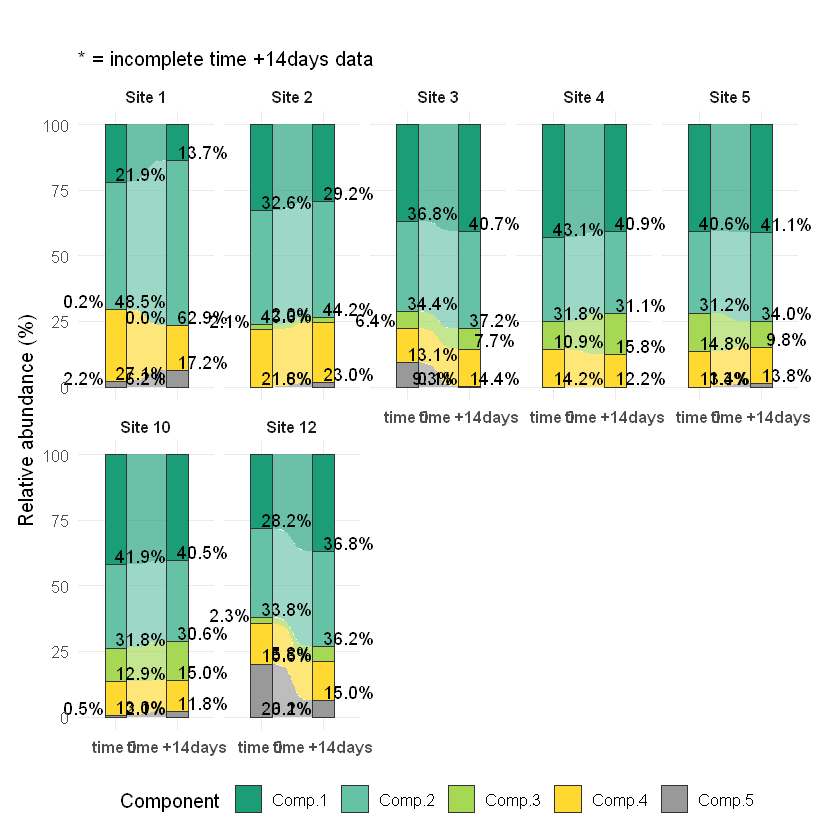

Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"
Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <92>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierung

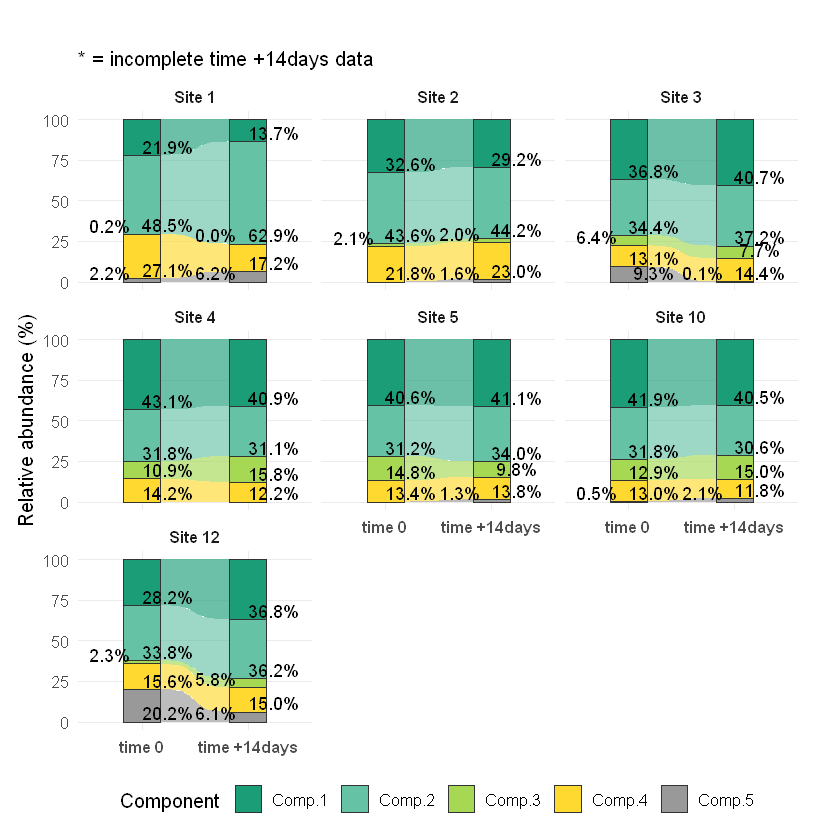

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <92>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <e2>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierungsfehler für 'Alluvial (DOC → BDOC) – Virkisa' in 'mbcsToSbcs': Punkt ersetzt <86>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"Konvertierung

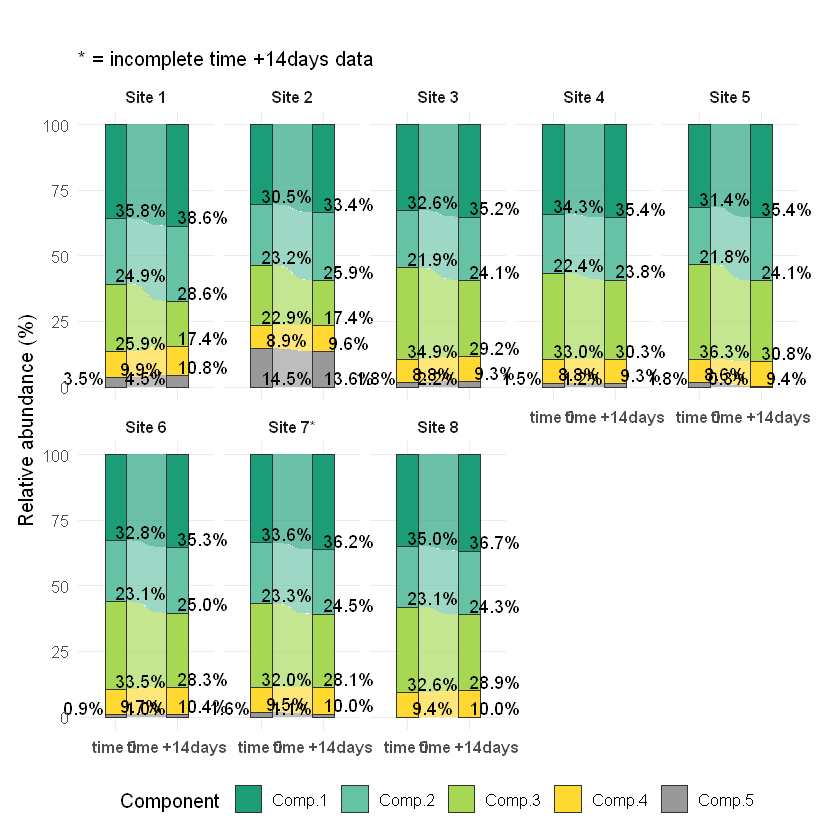

Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"
Warning message:
"Using ragg device as default. Ignoring `type` and `antialias` arguments"


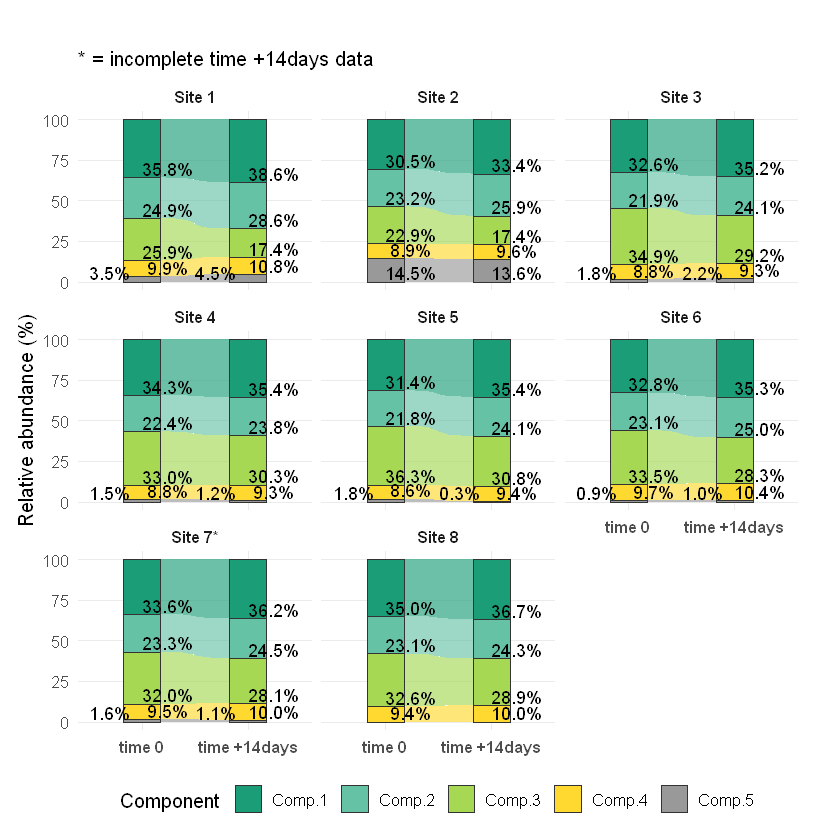

In [19]:
# ===============================
# DOC → BDOC Alluvial (PNG, A4)
# ===============================

# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
})

# ggalluvial laden (bei Bedarf einmalig installieren)
if (!requireNamespace("ggalluvial", quietly = TRUE)) {
  install.packages("ggalluvial")
}
library(ggalluvial)

# ---- Pfade ----
# Eingabe: Master-Components-Datei (Excel)
win_file <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
in_file  <- if (file.exists(win_file)) win_file else "/mnt/data/MASTER_DATA_Components.xlsx"

# Ausgabe: PNGs nach Vorgabe (kein PDF)
out_dir  <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)

png_land <- function(river) file.path(out_dir, paste0("Alluvial_DOC_to_BDOC_", river, "_A4_landscape.png"))
png_port <- function(river) file.path(out_dir, paste0("Alluvial_DOC_to_BDOC_", river, "_A4_portrait.png"))

# -------------------------------
# 1) Daten laden
# -------------------------------
df <- read_excel(in_file)

# -------------------------------
# 2) Problem-Sites (Summe _B ≠ 100 %)
# -------------------------------
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(dplyr::select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01 & !is.na(sum_time14)) %>%
  distinct(river_name, site_nr)

# -------------------------------
# 3) Long-Format DOC/BDOC (time 0 / time +14days)
# -------------------------------
df_long <- df %>%
  dplyr::select(
    river_name, group_nr, site_nr,
    pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
    pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B
  ) %>%
  pivot_longer(cols = c(pctComp.1:pctComp.5),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    df %>%
      dplyr::select(river_name, group_nr, site_nr,
                    pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B$", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Percent  = ifelse(!is.na(Percent) & Percent <= 1, Percent * 100, Percent),
    Time     = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# -------------------------------
# 4) Mittelwert je Site/Time & auf 100 % normieren
# -------------------------------
df_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# -------------------------------
# 5) Problem-Sites kennzeichnen & Site-Labels
# -------------------------------
df_norm <- df_norm %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel  = ifelse(is_problem, paste0("Site ", site_nr, "*"), paste0("Site ", site_nr))
  )
site_order <- df_norm %>% distinct(site_nr, SiteLabel) %>% arrange(site_nr) %>% pull(SiteLabel)
df_norm$SiteLabel <- factor(df_norm$SiteLabel, levels = site_order)

# -------------------------------
# 6) Farben & Anzeigenamen
# -------------------------------
component_labels <- c(
  "pctComp.1"="Comp.1","pctComp.2"="Comp.2","pctComp.3"="Comp.3",
  "pctComp.4"="Comp.4","pctComp.5"="Comp.5"
)
component_colors <- c(
  "Comp.1"="#1b9e77","Comp.2"="#66c2a5","Comp.3"="#a6d854",
  "Comp.4"="#ffd92f","Comp.5"="#999999"
)

df_norm <- df_norm %>%
  mutate(ComponentLabel = factor(component_labels[as.character(Component)],
                                 levels = names(component_colors)))

# -------------------------------
# 7) Nur komplette Paare (DOC & BDOC) + Site 0 entfernen (nur Vestari)
# -------------------------------
pairs_ok <- df_norm %>%
  distinct(river_name, site_nr, Time) %>%
  count(river_name, site_nr) %>%
  filter(n == 2) %>%
  transmute(river_name, site_nr)

df_plot <- df_norm %>%
  inner_join(pairs_ok, by = c("river_name","site_nr")) %>%
  # hier Filter: Site 0 nur bei Vestari entfernen
  filter(!(river_name == "Vestari_Joekulsa" & site_nr == 0))

# -------------------------------
# 8) Plot + Export (PNG, A4 quer & hochkant)
# -------------------------------
for (river in unique(df_plot$river_name)) {

  d <- df_plot %>%
    filter(river_name == river, !is.na(Percent)) %>%
    mutate(
      allu_id  = interaction(river_name, site_nr, ComponentLabel, drop = TRUE),
      Time     = factor(Time, levels = c("time 0", "time +14days")),
      Percent  = ifelse(Percent < 1e-6, 0, Percent),
      label_txt = ifelse(Percent > 0,
                         paste0(format(round(Percent, 1), nsmall = 1), "%"),
                         NA_character_),
      hjust_val = ifelse(Percent < 6.5, 1.25, 0)
    ) %>%
    add_count(allu_id, Time) %>%
    group_by(allu_id) %>%
    filter(n_distinct(Time) == 2) %>%
    ungroup()

  n_sites <- d %>% distinct(SiteLabel) %>% nrow()
  facet_cols_land <- min(max(4, ceiling(n_sites * 0.6)), n_sites)
  facet_cols_port <- max(2, min(3, n_sites))

  base <- ggplot(
    d,
    aes(x = Time,
        stratum  = ComponentLabel,
        alluvium = allu_id,
        y = Percent,
        fill = ComponentLabel)
  ) +
    ggalluvial::geom_alluvium(alpha = 0.65, knot.pos = 0.4) +
    ggalluvial::geom_stratum(width = 0.35, color = "grey20") +
    # Labels: größere Schriftgröße
    geom_text(
      data = d %>% filter(!is.na(label_txt)),
      aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0),
      vjust = -0.15, size = 3.8, na.rm = TRUE
    ) +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    coord_cartesian(ylim = c(0, 100), clip = "off") +
    labs(
      title = paste("Alluvial (DOC → BDOC) –", river),
      subtitle = "* = incomplete time +14days data",
      x = NULL, y = "Relative abundance (%)", fill = "Component"
    ) +
    theme_minimal(base_size = 12) +
    theme(
      plot.margin = margin(10, 25, 10, 10),
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text.x = element_text(face = "bold"),
      legend.position = "bottom"
    )

  p_alluvial_land <- base + facet_wrap(~ SiteLabel, scales = "fixed", ncol = facet_cols_land)
  p_alluvial_port <- base + facet_wrap(~ SiteLabel, scales = "fixed", ncol = facet_cols_port)

  print(p_alluvial_land)
  print(p_alluvial_port)

  ggsave(
    filename = png_land(river),
    plot = p_alluvial_land,
    width = 11.69, height = 8.27, units = "in",
    dpi = 300, device = "png", bg = "white", type = "cairo"
  )
  ggsave(
    filename = png_port(river),
    plot = p_alluvial_port,
    width = 8.27, height = 11.69, units = "in",
    dpi = 300, device = "png", bg = "white", type = "cairo"
  )
}

# ===== Ende =====


# Table

In [15]:
# =======================
# Ursprungstabellen (A, B) + Δ (B-A) je Fluss
# Anzeige in Jupyter + Speichern als CSV
# =======================

suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(stringr)
  library(tidyr); library(reshape2)
  library(knitr)     # für schöne Ausgabe in Jupyter
})

options(stringsAsFactors = FALSE)

# ----- Pfade -----
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Components"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ----- Daten -----
raw <- readxl::read_excel(data_path)

# SiteLabel sicherstellen
if (!"SiteLabel" %in% names(raw)) {
  raw <- raw %>% mutate(SiteLabel = paste0("S", site_nr))
}

# Komponenten-Spalten finden
all_names <- names(raw)
strip_suffix <- function(x) sub("(_A|_B)$", "", x)
is_comp <- grepl("^pctComp\\.[1-9]\\d*(?:(_A|_B))?$", all_names)
comp_all <- all_names[is_comp]
if (length(comp_all) == 0) stop("Keine Komponenten-Spalten wie 'pctComp.i' gefunden.")
bases <- unique(strip_suffix(comp_all))

col_A <- function(b) {
  cand <- comp_all[strip_suffix(comp_all) == b]
  if (b %in% cand) return(b)             # time 0
  a2 <- paste0(b, "_A")
  if (a2 %in% cand) return(a2)           # alternativ _A
  NA_character_
}
col_B <- function(b) {
  b2 <- paste0(b, "_B")
  if (b2 %in% comp_all) return(b2)       # +14 Tage
  NA_character_
}

pairs <- tibble::tibble(
  base  = bases,
  col_A = vapply(bases, col_A, character(1)),
  col_B = vapply(bases, col_B, character(1))
) %>% dplyr::filter(!is.na(col_A), !is.na(col_B))

# Long-Format
id_cols <- c("river_name","site_nr","SiteLabel")
long_A <- raw[, c(id_cols, pairs$col_A)] %>%
  melt(id.vars = id_cols, variable.name = "colname", value.name = "Percent") %>%
  mutate(base = strip_suffix(as.character(colname)), TimeLabel = "A") %>% select(-colname)
long_B <- raw[, c(id_cols, pairs$col_B)] %>%
  melt(id.vars = id_cols, variable.name = "colname", value.name = "Percent") %>%
  mutate(base = strip_suffix(as.character(colname)), TimeLabel = "B") %>% select(-colname)
df_long <- bind_rows(long_A, long_B)

# Prozent ggf. 0..1 → 0..100
rng <- range(df_long$Percent, na.rm = TRUE)
if (is.finite(rng[2]) && rng[2] <= 1.0001) df_long$Percent <- df_long$Percent * 100

# ComponentLabel (pctComp.{i} -> Ci)
comp_idx <- as.integer(str_extract(df_long$base, "(?<=pctComp\\.)\\d+"))
df_long <- df_long %>% mutate(ComponentLabel = paste0("C", comp_idx))

# ======= je Fluss: A, B, Δ =======
for (river in unique(df_long$river_name)) {
  d_riv <- df_long %>%
    filter(river_name == river) %>%
    # Vestari: Standort 0 raus
    filter(!(grepl("Vestari", river_name, ignore.case = TRUE) & site_nr == 0))

  # Voraggregieren je Component × Site × Zeit
  agg <- d_riv %>%
    group_by(ComponentLabel, SiteLabel, TimeLabel) %>%
    summarise(Percent = sum(Percent, na.rm = TRUE), .groups = "drop")

  # --- Day 0 (A) ---
  tab_A <- agg %>%
    filter(TimeLabel == "A") %>%
    select(ComponentLabel, SiteLabel, Percent) %>%
    pivot_wider(names_from = SiteLabel, values_from = Percent) %>%
    arrange(ComponentLabel)
  cat("\n###", river, "- Components Day 0\n")
  print(knitr::kable(tab_A, digits = 2))
  write.csv(tab_A, file.path(out_dir, sprintf("%s_Components_day0.csv", river)), row.names = FALSE)

  # --- Day +14 (B) ---
  tab_B <- agg %>%
    filter(TimeLabel == "B") %>%
    select(ComponentLabel, SiteLabel, Percent) %>%
    pivot_wider(names_from = SiteLabel, values_from = Percent) %>%
    arrange(ComponentLabel)
  cat("\n###", river, "- Components Day +14\n")
  print(knitr::kable(tab_B, digits = 2))
  write.csv(tab_B, file.path(out_dir, sprintf("%s_Components_day14.csv", river)), row.names = FALSE)

  # --- Δ (B − A) ---
  delta <- agg %>%
    pivot_wider(names_from = TimeLabel, values_from = Percent) %>%
    mutate(delta_pp = B - A) %>%
    select(ComponentLabel, SiteLabel, delta_pp) %>%
    pivot_wider(names_from = SiteLabel, values_from = delta_pp) %>%
    arrange(ComponentLabel)
  cat("\n###", river, "- Components Δ (B−A)\n")
  print(knitr::kable(delta, digits = 2))
  write.csv(delta, file.path(out_dir, sprintf("%s_Components_delta.csv", river)), row.names = FALSE)
}

cat("\nFertig. Dateien liegen in:\n", out_dir, "\n")



### Vestari_Joekulsa - Components Day 0


|ComponentLabel |    S1|   S10|   S12|    S2|    S3|    S4|    S5|
|:--------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|C1             | 43.83| 83.76| 56.32| 65.21| 73.64| 86.21| 81.52|
|C2             | 97.02| 63.63| 67.57| 87.18| 68.78| 63.66| 64.79|
|C3             |  0.42| 25.71|  4.53|  4.10| 12.79| 21.70| 26.01|
|C4             | 54.29| 25.92| 31.17| 43.51| 26.11| 28.42| 27.68|
|C5             |  4.44|  0.97| 40.41|  0.00| 18.69|  0.00|  0.00|

### Vestari_Joekulsa - Components Day +14


|ComponentLabel |     S1|   S10|   S12|    S2|    S3|    S4|    S5|
|:--------------|------:|-----:|-----:|-----:|-----:|-----:|-----:|
|C1             |  27.34| 81.00| 73.65| 58.49| 81.38| 81.79| 82.22|
|C2             | 125.87| 61.28| 72.46| 88.44| 74.36| 62.14| 67.98|
|C3             |   0.02| 30.00| 11.65|  4.01| 15.31| 31.60| 19.55|
|C4             |  34.33| 23.57| 29.99| 45.94| 28.73| 24.47| 27.68|
|C5             |  12.44|  4.15| 12

In [16]:
# =======================
# Ursprungstabellen (A, B) + Δ (B-A) + Δ% je Fluss
# Anzeige in Jupyter + Speichern als CSV
# =======================

suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(stringr)
  library(tidyr); library(reshape2)
  library(knitr)
})

options(stringsAsFactors = FALSE)

# ----- Pfade -----
data_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Sophia_Data.xls"
out_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Components"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# ----- Daten -----
raw <- readxl::read_excel(data_path)

# SiteLabel sicherstellen
if (!"SiteLabel" %in% names(raw)) {
  if (!"site_nr" %in% names(raw)) stop("Spalte 'site_nr' fehlt.")
  raw <- raw %>% mutate(SiteLabel = paste0("S", site_nr))
}

# Komponenten-Spalten finden
all_names <- names(raw)
strip_suffix <- function(x) sub("(_A|_B)$", "", x)
is_comp <- grepl("^pctComp\\.[1-9]\\d*(?:(_A|_B))?$", all_names)
comp_all <- all_names[is_comp]
if (length(comp_all) == 0) stop("Keine Komponenten-Spalten wie 'pctComp.i' gefunden.")
bases <- unique(strip_suffix(comp_all))

col_A <- function(b) {
  cand <- comp_all[strip_suffix(comp_all) == b]
  if (b %in% cand) return(b)             # time 0
  a2 <- paste0(b, "_A")
  if (a2 %in% cand) return(a2)           # alternativ _A
  NA_character_
}
col_B <- function(b) {
  b2 <- paste0(b, "_B")
  if (b2 %in% comp_all) return(b2)       # +14 Tage
  NA_character_
}

pairs <- tibble::tibble(
  base  = bases,
  col_A = vapply(bases, col_A, character(1)),
  col_B = vapply(bases, col_B, character(1))
) %>% dplyr::filter(!is.na(col_A), !is.na(col_B))

# Long-Format
id_cols <- c("river_name","site_nr","SiteLabel")
long_A <- raw[, c(id_cols, pairs$col_A), drop = FALSE] %>%
  melt(id.vars = id_cols, variable.name = "colname", value.name = "Percent") %>%
  mutate(base = strip_suffix(as.character(colname)), TimeLabel = "A") %>% select(-colname)
long_B <- raw[, c(id_cols, pairs$col_B), drop = FALSE] %>%
  melt(id.vars = id_cols, variable.name = "colname", value.name = "Percent") %>%
  mutate(base = strip_suffix(as.character(colname)), TimeLabel = "B") %>% select(-colname)
df_long <- bind_rows(long_A, long_B)

# Prozent ggf. 0..1 → 0..100
rng <- range(df_long$Percent, na.rm = TRUE)
if (is.finite(rng[2]) && rng[2] <= 1.0001) df_long$Percent <- df_long$Percent * 100

# ComponentLabel (pctComp.{i} -> Ci)
comp_idx <- as.integer(str_extract(df_long$base, "(?<=pctComp\\.)\\d+"))
df_long <- df_long %>% mutate(ComponentLabel = paste0("C", comp_idx))

# --- Helper: Vestari-Spaltenordnung anwenden (S1,S2,S3,S4,S5,S10,S12, dann Rest) ---
order_sites_vestari <- function(df) {
  if (!all(c("ComponentLabel") %in% names(df))) return(df)
  desired <- c("ComponentLabel","S1","S2","S3","S4","S5","S10","S12")
  keep <- intersect(desired, names(df))
  rest <- setdiff(names(df), keep)
  df[, c(keep, setdiff(rest, "ComponentLabel")), drop = FALSE]
}

# ======= je Fluss: A, B, Δ, Δ% =======
for (river in unique(df_long$river_name)) {
  d_riv <- df_long %>%
    filter(river_name == river) %>%
    # Vestari: Standort 0 raus
    filter(!(grepl("Vestari", river_name, ignore.case = TRUE) & site_nr == 0))

  # Voraggregieren je Component × Site × Zeit
  agg <- d_riv %>%
    group_by(ComponentLabel, SiteLabel, TimeLabel) %>%
    summarise(Percent = sum(Percent, na.rm = TRUE), .groups = "drop")

  # --- Wide A & B (für Δ%) ---
  wide_AB <- agg %>%
    pivot_wider(names_from = TimeLabel, values_from = Percent)

  # --- Day 0 (A) ---
  tab_A <- wide_AB %>%
    select(ComponentLabel, SiteLabel, A) %>%
    rename(Percent = A) %>%
    pivot_wider(names_from = SiteLabel, values_from = Percent) %>%
    arrange(ComponentLabel)
  if (grepl("Vestari", river, ignore.case = TRUE)) tab_A <- order_sites_vestari(tab_A)
  cat("\n###", river, "- Components Day 0\n")
  print(knitr::kable(tab_A, digits = 2))
  write.csv(tab_A, file.path(out_dir, sprintf("%s_Components_day0.csv", river)), row.names = FALSE)

  # --- Day +14 (B) ---
  tab_B <- wide_AB %>%
    select(ComponentLabel, SiteLabel, B) %>%
    rename(Percent = B) %>%
    pivot_wider(names_from = SiteLabel, values_from = Percent) %>%
    arrange(ComponentLabel)
  if (grepl("Vestari", river, ignore.case = TRUE)) tab_B <- order_sites_vestari(tab_B)
  cat("\n###", river, "- Components Day +14\n")
  print(knitr::kable(tab_B, digits = 2))
  write.csv(tab_B, file.path(out_dir, sprintf("%s_Components_day14.csv", river)), row.names = FALSE)

  # --- Δ (B − A) in %-Punkten ---
  delta <- wide_AB %>%
    mutate(delta_pp = B - A) %>%
    select(ComponentLabel, SiteLabel, delta_pp) %>%
    pivot_wider(names_from = SiteLabel, values_from = delta_pp) %>%
    arrange(ComponentLabel)
  if (grepl("Vestari", river, ignore.case = TRUE)) delta <- order_sites_vestari(delta)
  cat("\n###", river, "- Components Δ (B−A) [percentage points]\n")
  print(knitr::kable(delta, digits = 2))
  write.csv(delta, file.path(out_dir, sprintf("%s_Components_delta.csv", river)), row.names = FALSE)

  # --- Δ% relativ zu Day 0: 100*(B-A)/A ---
  delta_pct <- wide_AB %>%
    mutate(delta_pct = ifelse(!is.na(A) & A != 0, 100*(B - A)/A, NA_real_)) %>%
    select(ComponentLabel, SiteLabel, delta_pct) %>%
    pivot_wider(names_from = SiteLabel, values_from = delta_pct) %>%
    arrange(ComponentLabel)
  if (grepl("Vestari", river, ignore.case = TRUE)) delta_pct <- order_sites_vestari(delta_pct)
  cat("\n###", river, "- Components Δ% (relative to Day 0)\n")
  print(knitr::kable(delta_pct, digits = 1))
  write.csv(delta_pct, file.path(out_dir, sprintf("%s_Components_delta_pct.csv", river)), row.names = FALSE)
}

cat("\nFertig. Dateien liegen in:\n", out_dir, "\n")



### Vestari_Joekulsa - Components Day 0


|ComponentLabel |    S1|    S2|    S3|    S4|    S5|   S10|   S12|
|:--------------|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|C1             | 43.83| 65.21| 73.64| 86.21| 81.52| 83.76| 56.32|
|C2             | 97.02| 87.18| 68.78| 63.66| 64.79| 63.63| 67.57|
|C3             |  0.42|  4.10| 12.79| 21.70| 26.01| 25.71|  4.53|
|C4             | 54.29| 43.51| 26.11| 28.42| 27.68| 25.92| 31.17|
|C5             |  4.44|  0.00| 18.69|  0.00|  0.00|  0.97| 40.41|

### Vestari_Joekulsa - Components Day +14


|ComponentLabel |     S1|    S2|    S3|    S4|    S5|   S10|   S12|
|:--------------|------:|-----:|-----:|-----:|-----:|-----:|-----:|
|C1             |  27.34| 58.49| 81.38| 81.79| 82.22| 81.00| 73.65|
|C2             | 125.87| 88.44| 74.36| 62.14| 67.98| 61.28| 72.46|
|C3             |   0.02|  4.01| 15.31| 31.60| 19.55| 30.00| 11.65|
|C4             |  34.33| 45.94| 28.73| 24.47| 27.68| 23.57| 29.99|
|C5             |  12.44|  3.12|  0